In [10]:
!pip install -qq bm3d

In [11]:
import numpy as np 
import bm3d 
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio , structural_similarity
import matplotlib.pyplot as plt

In [12]:
SAMPLE_SEISMIC_PATH = './test2_seismic.npy' # using facies mark dataset test set
clean = np.load(SAMPLE_SEISMIC_PATH)
# clean = np.random.randn(601,200,255)

In [16]:
clean.shape

(601, 200, 255)

In [13]:
# preprocess
abs_max = np.percentile(np.abs(clean), 0.99)
clean_norm = np.clip(clean, -abs_max, abs_max) / abs_max

# sanity check 
display(np.min(clean_norm), np.max(clean_norm))

-1.0

1.0

In [22]:
# add noise 
noise_mode = ['gaussian', 'poisson']
noise_factors = [0.1,0.5,0.9,'poisson']

noisy_1 = random_noise(clean_norm , seed=42, mode = 'gaussian', mean= 0 , var=noise_factors[0], clip=True)
noisy_2 = random_noise(clean_norm , seed=42, mode = 'gaussian', mean = 0, var=noise_factors[1], clip=True)
noisy_3 = random_noise(clean_norm , seed=42, mode = 'gaussian', mean =0 , var=noise_factors[2], clip=True)
noisy_4 = random_noise(clean_norm , seed=42, mode = 'poisson', clip=True)

noisy_norm = [noisy_1, noisy_2, noisy_3, noisy_4]

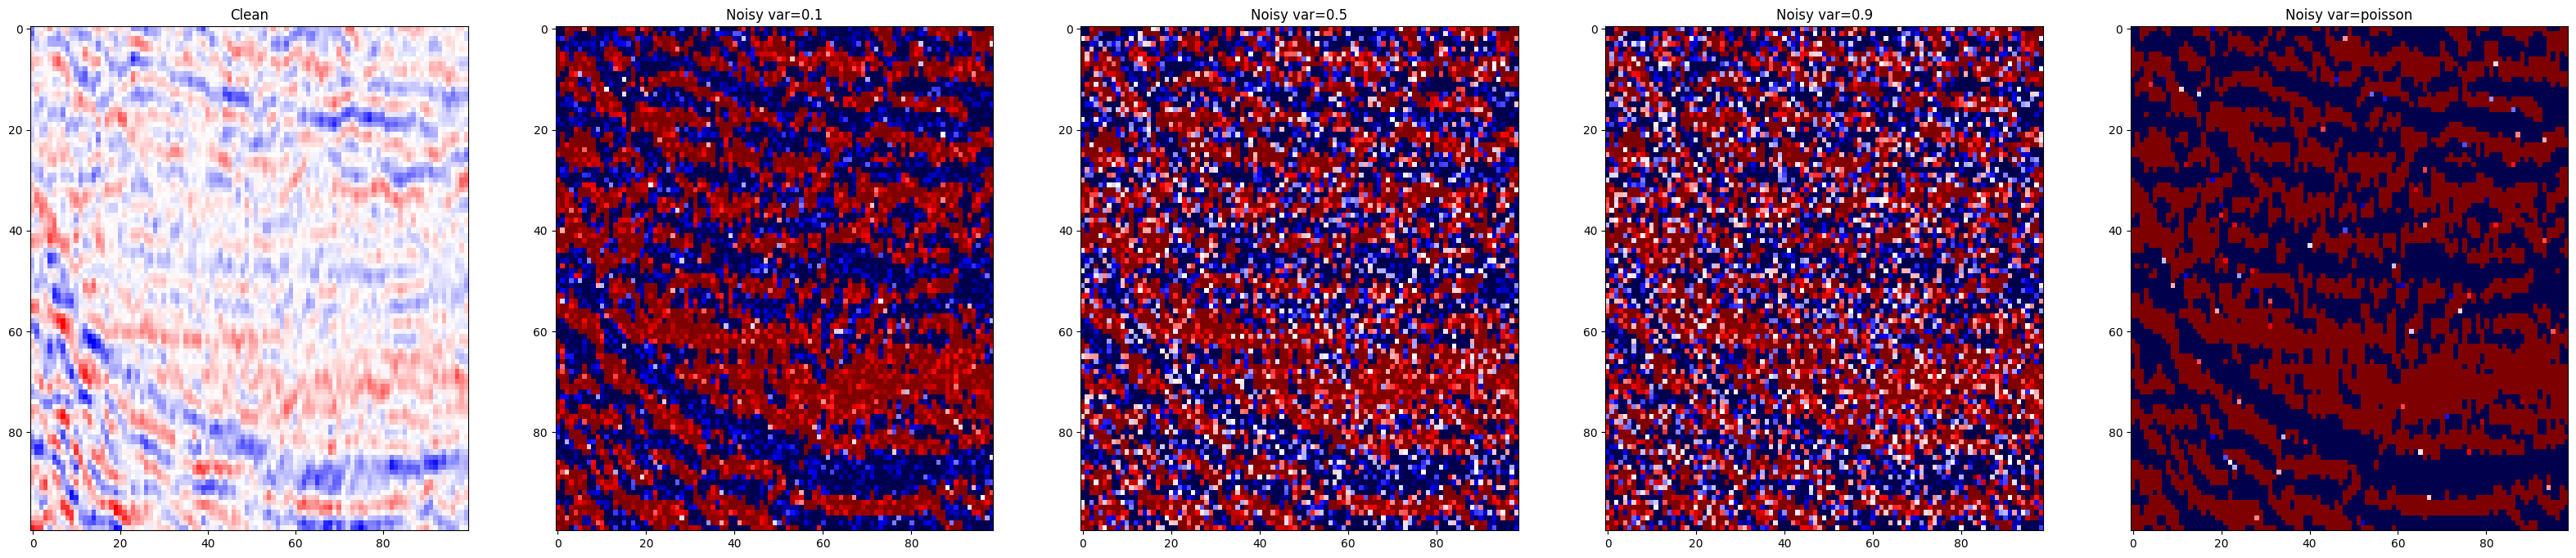

In [23]:
fig,ax = plt.subplots(ncols=5, figsize=(8*5,8))

ax[0].imshow(clean[0,100:200,100:200].T, vmin=-1.0, vmax=1.0, aspect='auto', cmap='seismic')
ax[0].set_title(f'Clean' )
for i, image in enumerate(noisy_norm) : 
    ax[i+1].imshow(noisy_norm[i][0,100:199,100:200].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')
    ax[i+1].set_title(f'Noisy var={noise_factors[i]}' )
    
    

In [24]:
def denoise_bm3d(noisy, var, mode='2d') : 
    denoised = np.zeros_like(noisy)
    for i in range(noisy.shape[0]) : 
        denoised[i] = bm3d.bm3d(noisy[i,:,:], sigma_psd=var**0.5, stage_arg = bm3d.BM3DStages.ALL_STAGES)

    return denoised

  
denoised_norm = []

%timeit
denoised_norm.append(denoise_bm3d(noisy_1, 0.1))
denoised_norm.append(denoise_bm3d(noisy_2, 0.5))
denoised_norm.append(denoise_bm3d(noisy_3, 0.9))
denoised_norm.append(denoise_bm3d(noisy_4, 0.01))

In [25]:
# denoise using non-local-means 
from skimage.restoration import denoise_nl_means , denoise_tv_bregman , denoise_wavelet , estimate_sigma

denoised_norm_nlm = []

def denoise_nlm(noisy, var, mode='2d') : 
    denoised = np.zeros_like(noisy)
    for i in range(noisy.shape[0]) : 
        denoised[i] = denoise_nl_means(noisy[i,:,:], sigma=var**0.5, preserve_range=True, channel_axis=None)
    return denoised


denoised_norm_nlm.append(denoise_nlm(noisy_1, 0.1))
denoised_norm_nlm.append(denoise_nlm(noisy_2, 0.5))
denoised_norm_nlm.append(denoise_nlm(noisy_3, 0.9))
denoised_norm_nlm.append(denoise_nlm(noisy_4, 0.01))


In [26]:
# denoise using total variation method 
denoised_norm_tv = []

def denoise_tv(noisy, var, mode='2d') : 
    denoised = np.zeros_like(noisy)
    for i in range(noisy.shape[0]) : 
        denoised[i] = denoise_tv_bregman(noisy[i,:,:], channel_axis=None, multichannel=False)
    return denoised


denoised_norm_tv.append(denoise_tv(noisy_1, 0.1))
denoised_norm_tv.append(denoise_tv(noisy_2, 0.5))
denoised_norm_tv.append(denoise_tv(noisy_3, 0.9))
denoised_norm_tv.append(denoise_tv(noisy_4, 0.01))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\skimage\_shared\utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_bregman`. It will be removed in version 1.0. Please use `channel_axis` instead.
  warnings.warn(self.warning_msg.format(


In [27]:
# denoise using wavelet method 
denoised_norm_wav = []

def denoise_wav(noisy, var, mode='2d') : 
    denoised = np.zeros_like(noisy)
    for i in range(noisy.shape[0]) : 
        denoised[i] = denoise_wavelet(noisy[i,:,:], sigma=var ** 0.5, channel_axis=None)
    return denoised


denoised_norm_wav.append(denoise_wav(noisy_1, 0.1))
denoised_norm_wav.append(denoise_wav(noisy_2, 0.5))
denoised_norm_wav.append(denoise_wav(noisy_3, 0.9))
denoised_norm_wav.append(denoise_wav(noisy_4, 0.01))

In [36]:
# psnr , ssim comparison 
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

noisy_psnr = []
noisy_ssim = []

psnr_bm3d = []
psnr_wav = []
psnr_tv = []
psnr_nlm = []

ssim_bm3d = []
ssim_wav = []
ssim_tv = []
ssim_nlm = []



for i in range(len(noisy_norm)) :  
    noisy_psnr.append(peak_signal_noise_ratio(clean_norm,noisy_norm[i] ))
    psnr_bm3d.append(peak_signal_noise_ratio(clean_norm,denoised_norm[i]))
    psnr_tv.append(peak_signal_noise_ratio(clean_norm,denoised_norm_tv[i]))
    psnr_nlm.append(peak_signal_noise_ratio(clean_norm,denoised_norm_nlm[i]))
    psnr_wav.append(peak_signal_noise_ratio(clean_norm,denoised_norm_wav[i]))

    noisy_ssim.append(structural_similarity(clean_norm,noisy_norm[i]))
    ssim_bm3d.append(structural_similarity(clean_norm,denoised_norm[i]))
    ssim_wav.append(structural_similarity(clean_norm,denoised_norm_wav[i]))
    ssim_tv.append(structural_similarity(clean_norm,denoised_norm_tv[i]))
    ssim_nlm.append(structural_similarity(clean_norm,denoised_norm_nlm[i]))



In [43]:
import pandas as pd 
psnr_df = pd.DataFrame(index = [0.1, 0.5, 0.9 , 'p'], columns = ['noisy', 'bm3d', 'tv', 'nlm', 'wav'] ,
                       data ={'noisy' : noisy_psnr, 'bm3d' : psnr_bm3d, 'tv' : psnr_tv, 'nlm' : psnr_nlm, 'wav' :  psnr_wav})

psnr_df

,noisy,bm3d,tv,nlm,wav
0.1,18.998963,17.794601,17.703238,19.126833,18.136759
0.5,12.065343,11.665094,13.003860,10.424252,9.587047
0.9,9.761645,10.049021,11.047454,7.017460,8.213116
p,60.005171,43.843490,22.877243,45.732513,46.695903


In [45]:
ssim_df = pd.DataFrame(index = [0.1, 0.5, 0.9 , 'p'], columns = ['noisy', 'bm3d', 'tv', 'nlm', 'wav'] ,
                       data ={'noisy' : noisy_ssim, 'bm3d' : ssim_bm3d, 'tv' : ssim_tv, 'nlm' : ssim_nlm, 'wav' :  ssim_wav})

ssim_df

,noisy,bm3d,tv,nlm,wav
0.1,0.932778,0.921589,0.915595,0.941148,0.922423
0.5,0.727941,0.643079,0.740709,0.487533,0.437373
0.9,0.578500,0.467310,0.605641,0.046886,0.226676
p,0.999940,0.999724,0.973102,0.999747,0.999850


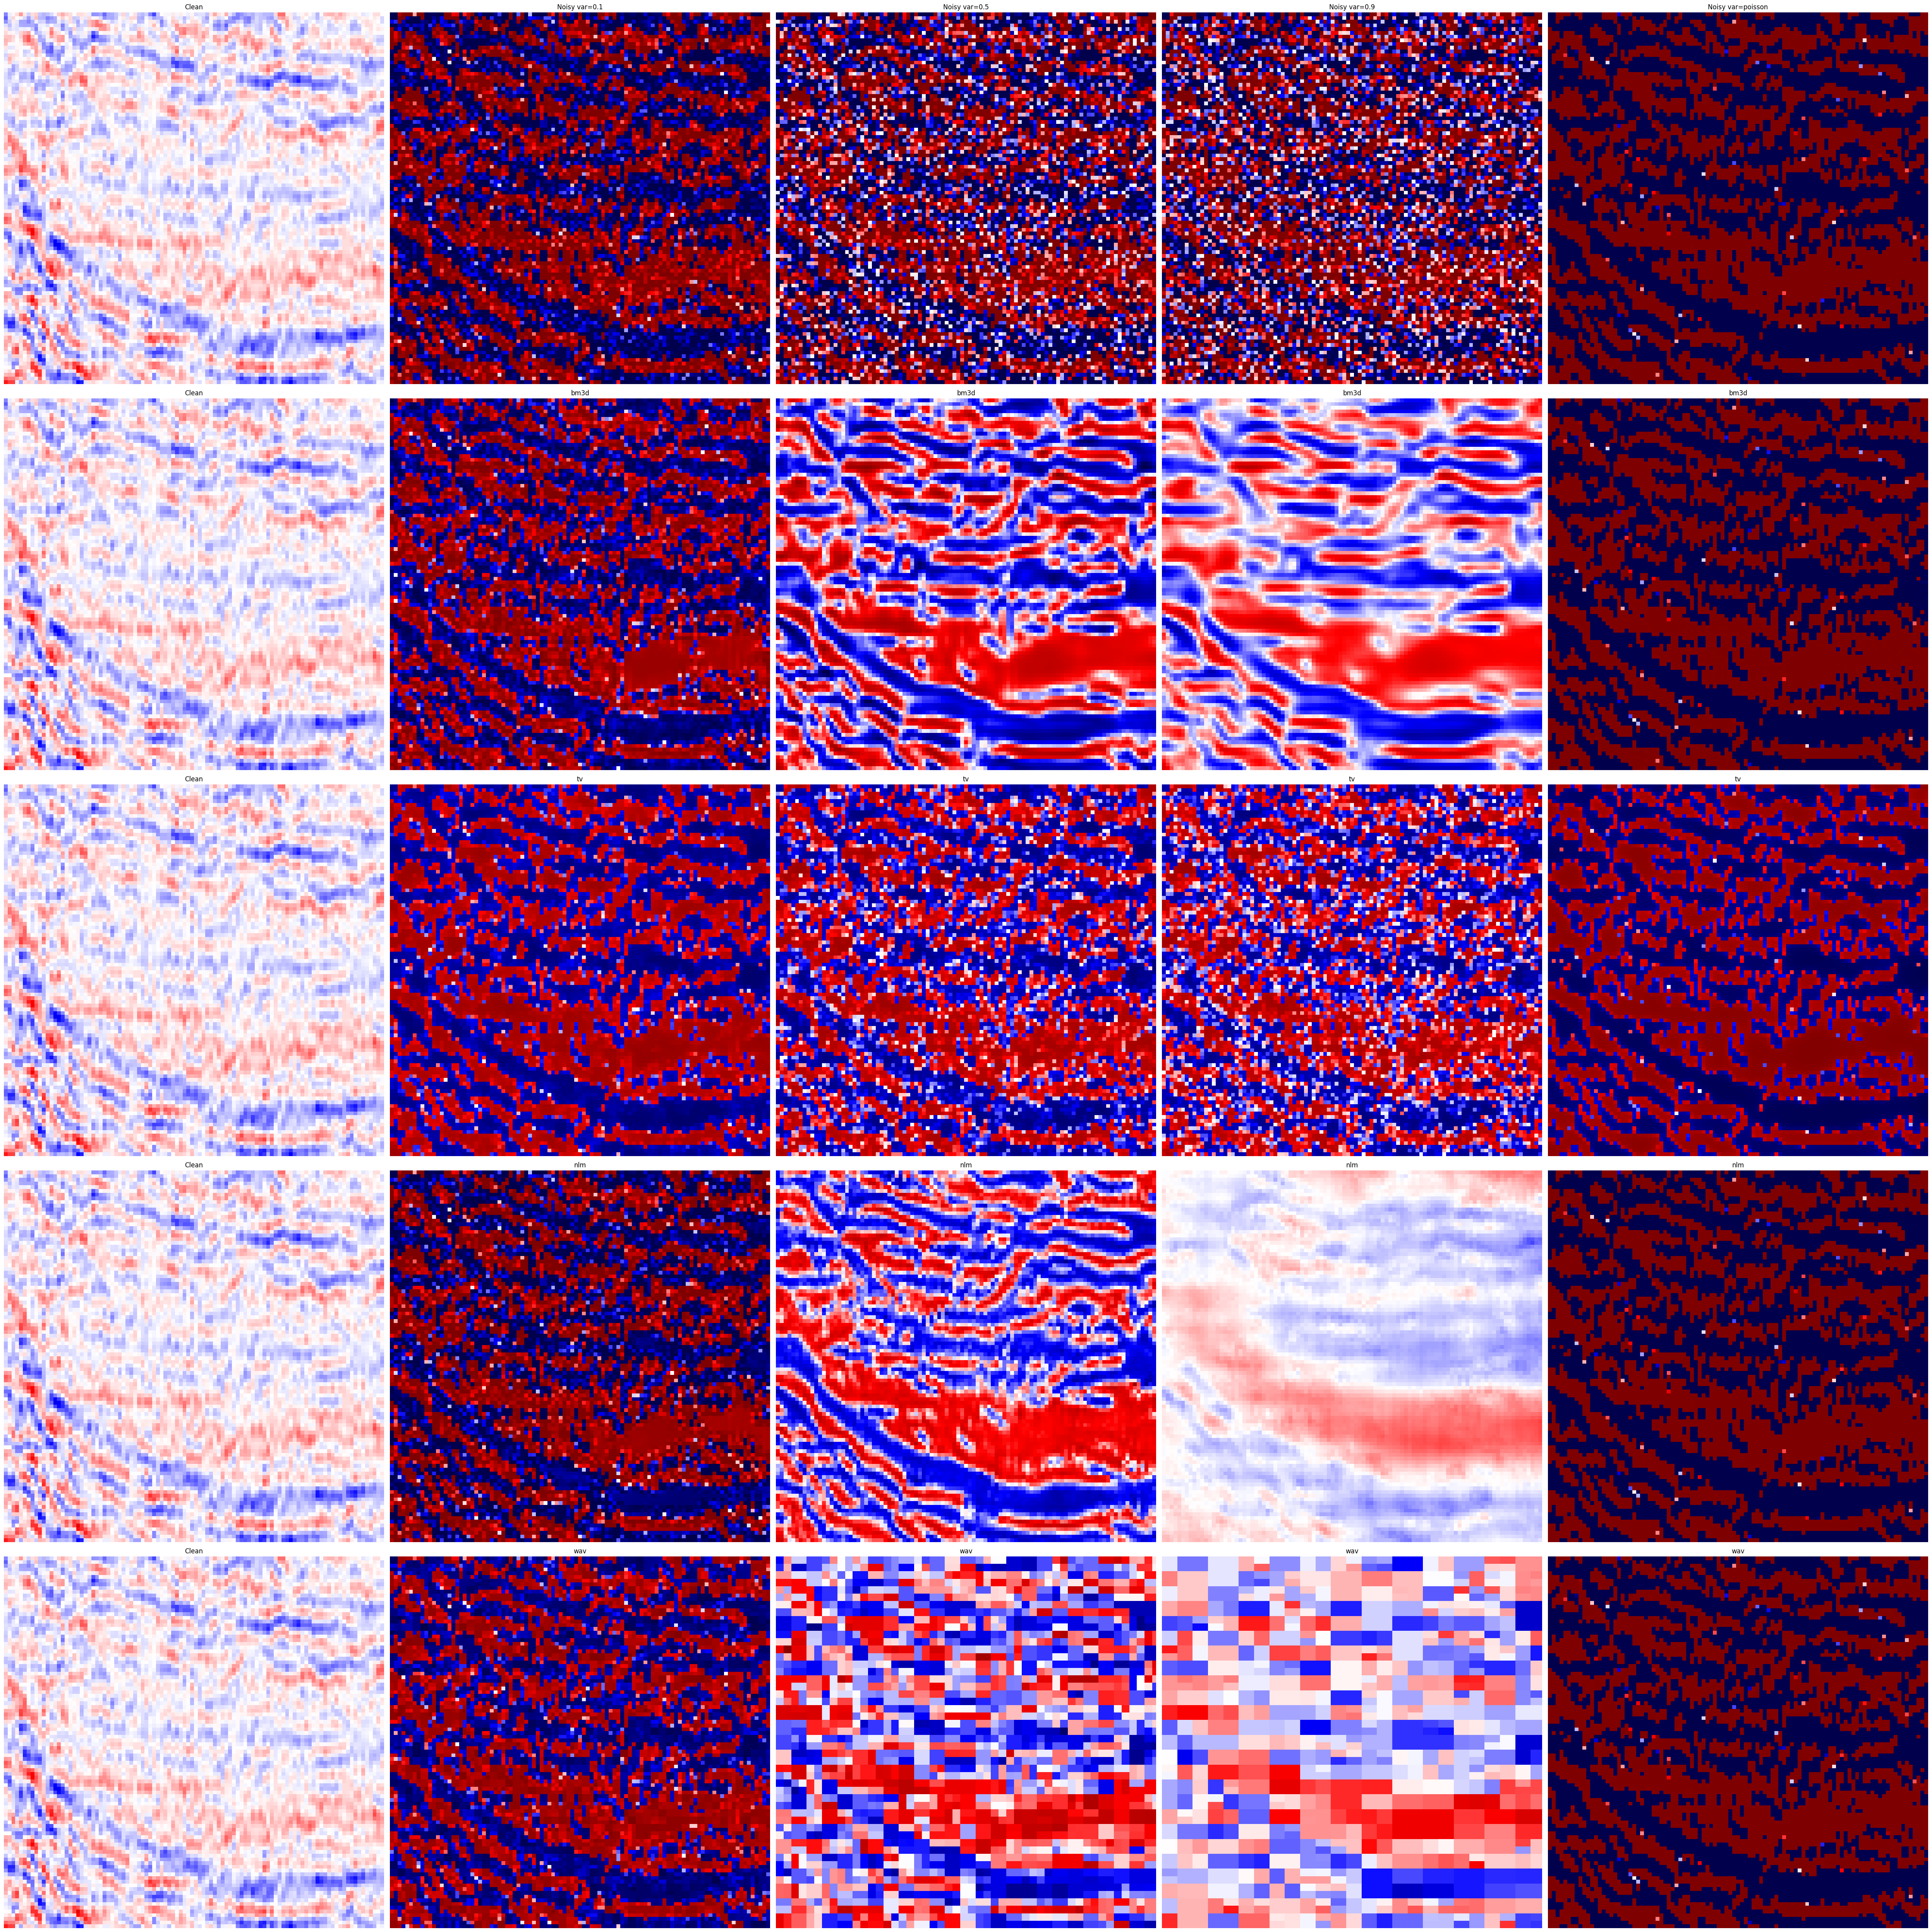

In [53]:
# plotting results 

fig,ax = plt.subplots(ncols=5 , nrows=5 , figsize=(10*5,10*5))

for i in range(5) : 
    ax[i,0].imshow(clean[0,100:200,100:200].T, vmin=-1.0, vmax=1.0, aspect='auto', cmap='seismic')
    ax[i,0].set_title(f'Clean' )
    ax[i, 0].axis('off')
for i, image in enumerate(noisy_norm) : 
    ax[0,i+1].imshow(noisy_norm[i][0,100:199,100:200].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')
    ax[0,i+1].set_title(f'Noisy var={noise_factors[i]}' )
    ax[0, i+1].axis('off')
    
for i, image in enumerate(denoised_norm) : 
    ax[1,i+1].imshow(denoised_norm[i][0,100:199,100:200].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')
    ax[1,i+1].set_title('bm3d' )
    ax[1,i+1].axis('off')
    
for i, image in enumerate(denoised_norm_tv) : 

    ax[2,i+1].imshow(denoised_norm_tv[i][0,100:199,100:200].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')
    ax[2,i+1].set_title('tv' )
    ax[2,i+1].axis('off')
    
for i, image in enumerate(denoised_norm_nlm) : 

    ax[3,i+1].imshow(denoised_norm_nlm[i][0,100:199,100:200].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')
    ax[3,i+1].set_title('nlm' )
    ax[3,i+1].axis('off')
    
for i, image in enumerate(denoised_norm_wav) : 

    ax[4,i+1].imshow(denoised_norm_wav[i][0,100:199,100:200].T, vmin=-1, vmax=1, aspect='auto', cmap='seismic')
    ax[4,i+1].set_title('wav' )
    ax[4,i+1].axis('off')

plt.tight_layout()
plt.axis('off')
plt.show()